In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
import joblib
import pickle

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
def process_reppu_data():
    #path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/REPPU/200/pbig5min.dat' #Ubuntu
    path = r'/home/sachin/Documents/NIPR/Research/Data/REPPU/pbig1min.dat' #Server

    #read the REPPU data
    with open (path) as f:
        rectype = np.dtype(np.float32)
        reppu_data = np.fromfile(f, rectype) #size = 109,900,800

    reppu_data = reppu_data.reshape(-1,30,80)
    #reppu_data = reppu_data.mean(axis=1).mean(axis=1) #integrate over the 30x80 grid

    #load MHD dates to match with REPPU data
    mhd_data = pd.read_csv('mhd_dates.csv')
    expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
        for start, end in zip(mhd_data['start'], mhd_data['end'])])
    
    time = np.arange(1440)
    dt = []
    for day in expanded_dt:
        for t in time:
            dt.append(day + pd.Timedelta(minutes=t*1))
    dt = np.array(dt) #convert from list to numpy array
    df = pd.DataFrame(reppu_data, index=dt)
    df = df.rename(columns={0:'pot'})
    df.reset_index(inplace=True)
    df.rename(columns={'index':'dt'}, inplace=True)

    return df

reppu_df = process_reppu_data()
reppu_df   

ValueError: Must pass 2-d input. shape=(228960, 30, 80)

In [4]:
def process_omni_and_merge(reppu_df):
    reppu_df = reppu_df.copy()
    
    omni_df = pd.read_csv('omni_mhd_5min.csv')
    #omni_df = pd.read_csv('omni_add-feats_mhd_5min.csv')
    omni_df = omni_df.interpolate()
    #omni_df = omni_df.ffill().bfill() #interpolate missing values
    #omni_df = omni_df.dropna() 
    omni_df['dt'] = pd.to_datetime(omni_df['dt'])

    #merge the REPPU and OMNI data
    df = pd.merge(reppu_df, omni_df, on='dt', how='outer')
    #df = df[(df['dt'] >= '2021-12-01') & (df['dt'] <= '2022-01-24')]
    #df = df[(df['dt'] >= '2021-12-01') & (df['dt'] <= '2021-12-02')]
    #df = df[(df['dt'] >= '2021-05-10') & (df['dt'] <= '2021-05-15')] #Kp 7 storm
    df = df[(df['dt'] >= '2022-07-01 00:00:00') & (df['dt'] <= '2022-07-30 23:59:00')] #7 window
    df['pot'] = df['pot'] * 1e-3
    #interpolate
    df = df.interpolate()

    return df.reset_index(drop=True)

df = process_omni_and_merge(reppu_df)
df

/tmp/ipykernel_25014/369454973.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  omni_df = omni_df.interpolate()


,dt,pot,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle
0,2022-07-01 00:00:00,-8.954549,-1.51,-0.090,351.0,4.50,0.352885
1,2022-07-01 00:01:00,-8.217284,-1.50,-0.114,350.4,4.46,0.352224
2,2022-07-01 00:02:00,-7.373014,-1.49,-0.138,349.8,4.42,0.351564
3,2022-07-01 00:03:00,-6.258748,-1.48,-0.162,349.2,4.38,0.350904
4,2022-07-01 00:04:00,-5.868861,-1.47,-0.186,348.6,4.34,0.350244
...,...,...,...,...,...,...,...
43195,2022-07-30 23:55:00,-6.550199,-6.48,-1.000,345.0,11.57,0.275340
43196,2022-07-30 23:56:00,-6.405646,-6.48,-1.000,345.0,11.57,0.275340
43197,2022-07-30 23:57:00,-6.196533,-6.48,-1.000,345.0,11.57,0.275340
43198,2022-07-30 23:58:00,-6.239224,-6.48,-1.000,345.0,11.57,0.275340


In [5]:
def single_feat_df(df, lookback, var):
    df = df.copy()
    #df = df[['dt',var]]

    df.set_index('dt', inplace=True)
    
    for i in range(1, lookback+1):
        #df[f'{var}(t-{i})'] = df[var].shift(i)
        df[f'BY_GSE(t-{i})'] = df['BY_GSE'].shift(i)
        df[f'BZ_GSE(t-{i})'] = df['BZ_GSE'].shift(i)
        df[f'flow_speed(t-{i})'] = df['flow_speed'].shift(i)
        df[f'proton_density(t-{i})'] = df['proton_density'].shift(i)
        df[f'tilt_angle(t-{i})'] = df['tilt_angle'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

feat = 'pot'
df = single_feat_df(df, 6, feat)
df

,pot,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,BY_GSE(t-1),BZ_GSE(t-1),flow_speed(t-1),proton_density(t-1),...,BY_GSE(t-5),BZ_GSE(t-5),flow_speed(t-5),proton_density(t-5),tilt_angle(t-5),BY_GSE(t-6),BZ_GSE(t-6),flow_speed(t-6),proton_density(t-6),tilt_angle(t-6)
dt,,,,,,,,,,,,,,,,,,,,,
2022-07-01 00:06:00,-4.732895,-1.502,-0.218,347.8,4.298,0.348929,-1.460,-0.210,348.0,4.300,...,-1.500,-0.114,350.4,4.46,0.352224,-1.510,-0.090,351.0,4.500,0.352885
2022-07-01 00:07:00,-4.319199,-1.544,-0.226,347.6,4.296,0.348274,-1.502,-0.218,347.8,4.298,...,-1.490,-0.138,349.8,4.42,0.351564,-1.500,-0.114,350.4,4.460,0.352224
2022-07-01 00:08:00,-4.223934,-1.586,-0.234,347.4,4.294,0.347619,-1.544,-0.226,347.6,4.296,...,-1.480,-0.162,349.2,4.38,0.350904,-1.490,-0.138,349.8,4.420,0.351564
2022-07-01 00:09:00,-4.593560,-1.628,-0.242,347.2,4.292,0.346964,-1.586,-0.234,347.4,4.294,...,-1.470,-0.186,348.6,4.34,0.350244,-1.480,-0.162,349.2,4.380,0.350904
2022-07-01 00:10:00,-4.804429,-1.670,-0.250,347.0,4.290,0.346309,-1.628,-0.242,347.2,4.292,...,-1.460,-0.210,348.0,4.30,0.349584,-1.470,-0.186,348.6,4.340,0.350244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-30 23:55:00,-6.550199,-6.480,-1.000,345.0,11.570,0.275340,-6.256,-0.886,343.6,11.520,...,-5.360,-0.430,338.0,11.32,0.278727,-5.338,-0.126,337.8,11.286,0.279409
2022-07-30 23:56:00,-6.405646,-6.480,-1.000,345.0,11.570,0.275340,-6.480,-1.000,345.0,11.570,...,-5.584,-0.544,339.4,11.37,0.278050,-5.360,-0.430,338.0,11.320,0.278727
2022-07-30 23:57:00,-6.196533,-6.480,-1.000,345.0,11.570,0.275340,-6.480,-1.000,345.0,11.570,...,-5.808,-0.658,340.8,11.42,0.277372,-5.584,-0.544,339.4,11.370,0.278050


In [6]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [7]:
def scale_split_tensor(df):

    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]

    #scale the data
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    split_train = int(0.8*len(X))#80% train, 20% test
    split_val_test = int(0.5*len(X[split_train:]))#10% val, 10% test

    #split the data
    X_train = X[:split_train]
    X_val = X[split_train:split_train+split_val_test]
    X_test = X[split_train+split_val_test:]

    y_train = y[:split_train]
    y_val = y[split_train:split_train+split_val_test]
    y_test = y[split_train+split_val_test:]


    #add exta dim for torch reqs
    X_train = X_train.reshape(-1, X.shape[1], 1)
    X_val = X_val.reshape(-1, X.shape[1], 1)
    X_test = X_test.reshape(-1, X.shape[1], 1)
    y_train = y_train.values.reshape(-1, 1)
    y_val = y_val.values.reshape(-1, 1)
    y_test = y_test.values.reshape(-1, 1)

    #convert to tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device) #convert to tensor and move to GPU
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    return X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor

X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor = scale_split_tensor(df)

In [8]:
X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_val_tensor.shape, y_test_tensor.shape

(torch.Size([34555, 35, 1]),
 torch.Size([4319, 35, 1]),
 torch.Size([4320, 35, 1]),
 torch.Size([34555, 1]),
 torch.Size([4319, 1]),
 torch.Size([4320, 1]))

In [9]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 16 #bigger batch size = faster training

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 35, 1]) torch.Size([16, 1])


In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 32, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [12]:
learning_rate = 0.001
num_epochs = 200
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_val_loss = float('inf')
patience = np.inf
wait = 0


In [13]:
train_losses = []
val_losses = []

start_time = dt.datetime.now()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device) #move to GPU
        
        output = model(x_batch) #forward pass
        loss = loss_function(output, y_batch) #calculate loss
        running_loss += loss.item() #accumulate loss
        
        optimizer.zero_grad() #zero gradients
        loss.backward() #backpropagation
        optimizer.step() #update weights

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad(): #val has no gradients because we are not training
        for batch_index, batch in enumerate(val_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            
            output = model(x_batch) 
            loss = loss_function(output, y_batch)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch: {epoch + 1}, Train Loss: {avg_train_loss:.3f} [kV], Val Loss: {avg_val_loss:.3f} [kV]')
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        wait = 0
        #torch.save(model.state_dict(), 'best_model.pth')
    else:
        wait += 1
        if wait >= patience:
            print(f"Validation loss did not improve for {patience} epochs. Stopping training.")
            end_time = dt.datetime.now()
            diff = end_time - start_time
            print(f'Training Time: {diff}')
            break

#best_model = model
#best_model.load_state_dict(torch.load('best_model.pth'))

Epoch: 1, Train Loss: 36.785 [kV], Val Loss: 56.340 [kV]
Epoch: 2, Train Loss: 34.703 [kV], Val Loss: 65.177 [kV]
Epoch: 3, Train Loss: 32.949 [kV], Val Loss: 62.012 [kV]
Epoch: 4, Train Loss: 31.689 [kV], Val Loss: 61.018 [kV]
Epoch: 5, Train Loss: 30.696 [kV], Val Loss: 55.068 [kV]
Epoch: 6, Train Loss: 30.053 [kV], Val Loss: 55.899 [kV]
Epoch: 7, Train Loss: 29.562 [kV], Val Loss: 66.527 [kV]
Epoch: 8, Train Loss: 28.168 [kV], Val Loss: 60.059 [kV]
Epoch: 9, Train Loss: 26.459 [kV], Val Loss: 62.894 [kV]
Epoch: 10, Train Loss: 24.909 [kV], Val Loss: 65.923 [kV]
Epoch: 11, Train Loss: 23.772 [kV], Val Loss: 65.440 [kV]
Epoch: 12, Train Loss: 22.363 [kV], Val Loss: 93.322 [kV]
Epoch: 13, Train Loss: 23.003 [kV], Val Loss: 71.090 [kV]
Epoch: 14, Train Loss: 22.090 [kV], Val Loss: 80.756 [kV]
Epoch: 15, Train Loss: 20.868 [kV], Val Loss: 70.962 [kV]
Epoch: 16, Train Loss: 19.583 [kV], Val Loss: 88.148 [kV]
Epoch: 17, Train Loss: 17.325 [kV], Val Loss: 90.570 [kV]
Epoch: 18, Train Loss: 

In [14]:
# Evaluate on the test set
test_loss = 0.0

model.eval()
with torch.no_grad():
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.3f}')

Test Loss: 76.797


In [15]:
X = df.iloc[:, 1:]
split_index = int(0.8*len(X))#80% train, 20% test
X_train = X[:split_index]

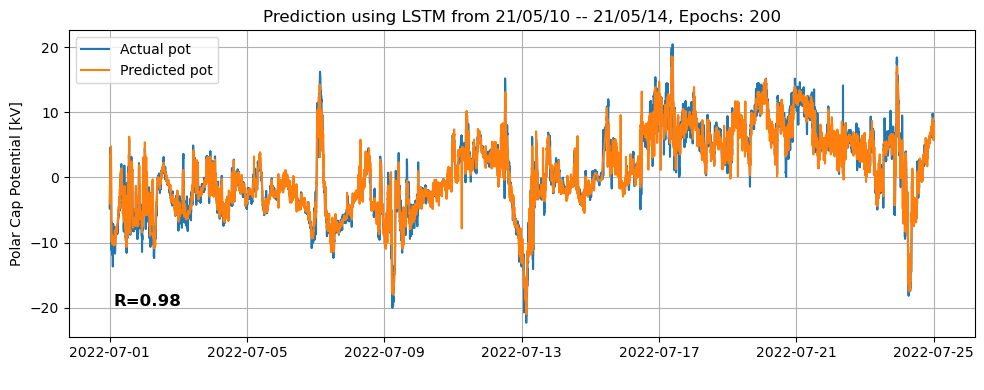

In [16]:
with torch.no_grad():
    predicted = model(X_train_tensor.to(device)).to('cpu')

plt.figure(figsize=(10, 4))
y_true = y_train_tensor.to('cpu')
R = np.corrcoef(predicted.squeeze(), y_true.squeeze())[0,1]

plt.plot(X_train.index, y_true,  label=f'Actual {feat}')
plt.plot(X_train.index, predicted, label=f'Predicted {feat}')

plt.title(f'Prediction using LSTM from 21/05/10 -- 21/05/14, Epochs: {num_epochs}')
plt.annotate(f'R={R:.2f}', xy=(0.05, 0.1), xycoords='axes fraction', fontsize=12,fontweight='bold')
plt.xlabel(' ')
plt.ylabel(f'Polar Cap Potential [kV]')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig(f'{feat}_lstm_dt.png', dpi=300)
#plt.show()